# UNet Training

In [1]:
from models_files.unet_import import UNet
import numpy as np
import h5py
from utils.training_utils import get_data_flat_raw
from utils.metrics import dice_coef
import tensorflow as tf

In [2]:
train_energies = np.arange(2, 42, 2)
train_energies = np.append(train_energies, [0.1])
direct = 'simulations/single_hits/'
num_runs = 500

train_images = get_data_flat_raw(direct, train_energies, num_runs, 'images')
train_labels = get_data_flat_raw(direct, train_energies, num_runs, 'labels')
print(train_images.shape)
print(train_labels.shape)

(315000, 32, 32, 1)
(315000, 32, 32, 1)


In [79]:
# val_energies = [28, 32]
# val_images = get_data_flat(direct, val_energies, num_runs, 'images')
# val_labels = get_data_flat(direct, val_energies, num_runs, 'labels')
# print(val_images.shape)
# print(val_labels.shape)

In [80]:
random_mask = np.arange(train_images.shape[0])
np.random.shuffle(random_mask)

In [81]:
train_images[random_mask] = train_images
train_labels[random_mask] = train_labels

In [85]:
img_width, img_height, img_channels = 32, 32, 1

model = UNet(img_width, img_height, img_channels)

# Compile model
model.compile(optimizer=tf.keras.optimizers.Adam(), 
              loss='binary_crossentropy', 
              metrics = [dice_coef])

# checkpoint
filepath = "models_saved/unet/unet-trial5-gpu-ep{epoch:02d}-dice{val_dice_coef:.4f}.h5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_dice_coef', verbose=1, save_best_only=True, mode='max')
csv_logger = tf.keras.callbacks.CSVLogger("models_history/unet_history_log_final.csv", append=True)
earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_dice_coef', min_delta=0.0, patience=4, verbose=1, mode='max')
callbacks_list = [checkpoint, earlystop, csv_logger]

In [86]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 1)]  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 32, 32, 1)    0           input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 32, 32, 16)   160         lambda_1[0][0]                   
__________________________________________________________________________________________________
dropout_9 (Dropout)             (None, 32, 32, 16)   0           conv2d_19[0][0]                  
____________________________________________________________________________________________

In [87]:
model.fit(train_images, train_labels, 
          batch_size=32, 
          epochs=50,
          validation_split=0.2,
          shuffle=True,
          callbacks=callbacks_list
         )

Train on 252000 samples, validate on 63000 samples
Epoch 1/50
251968/252000 [============================>.] - ETA: 0s - loss: 0.0067 - dice_coef: 0.9254
Epoch 00001: val_dice_coef improved from -inf to 0.95878, saving model to models_saved/unet/unet-trial5-gpu-ep01-dice0.9588.h5
252000/252000 [==============================] - 950s 4ms/sample - loss: 0.0067 - dice_coef: 0.9254 - val_loss: 0.0038 - val_dice_coef: 0.9588
Epoch 2/50
251968/252000 [============================>.] - ETA: 0s - loss: 0.0076 - dice_coef: 0.9369
Epoch 00002: val_dice_coef did not improve from 0.95878
252000/252000 [==============================] - 955s 4ms/sample - loss: 0.0076 - dice_coef: 0.9369 - val_loss: 0.0107 - val_dice_coef: 0.9138
Epoch 3/50
251968/252000 [============================>.] - ETA: 0s - loss: 0.0052 - dice_coef: 0.9409
Epoch 00003: val_dice_coef did not improve from 0.95878
252000/252000 [==============================] - 970s 4ms/sample - loss: 0.0052 - dice_coef: 0.9409 - val_loss: 0.0

KeyboardInterrupt: 

# DONE- TRAINING TILL HERE

# PLOTS

## Training/validation loss

ValueError: x and y must have same first dimension, but have shapes (10,) and (1,)

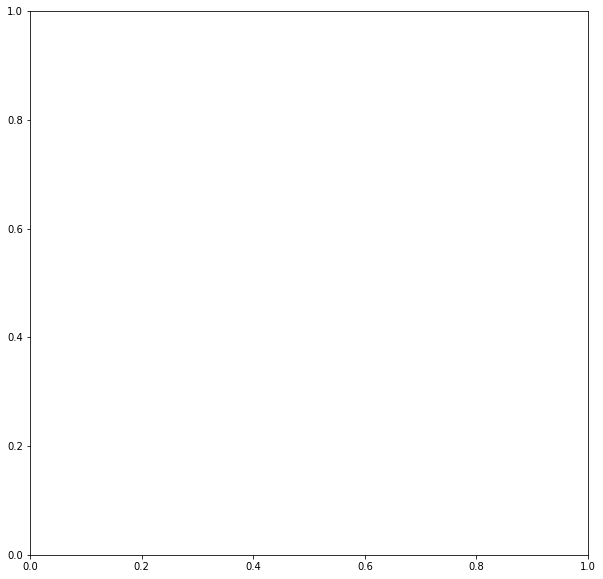

In [36]:
import matplotlib.pyplot as plt
%matplotlib inline

# Plot training & validation loss values
plt.figure(figsize=(10,10))
plt.plot(range(1,11), history.history['loss'])
plt.plot(range(1,11), history.history['val_loss'])
plt.title('Model loss per epoch')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.xlim((0.5,8.5))
plt.xticks(range(1,8,1))
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

## Training/validation dice coefficients

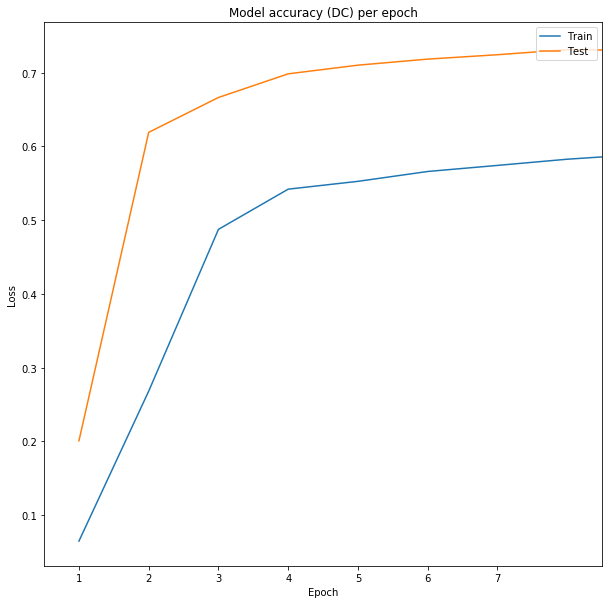

In [11]:
# Plot training & validation loss values
plt.figure(figsize=(10,10))
plt.plot(range(1,11), history.history['dice_coef'])
plt.plot(range(1,11), history.history['val_dice_coef'])
plt.title('Model accuracy (DC) per epoch')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.xlim((0.5,8.5))
plt.xticks(range(1,8,1))
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

# DEMO ON ONE IMAGE

In [44]:
model_path = "models_saved/unet/unet-trial1-gpu-ep02-dice0.97.h5"
model = tf.keras.models.load_model(model_path, custom_objects={'dice_coef' : dice_coef})


In [74]:
img = 150017
test_image = train_images[img, :, :, :]
test_image = np.expand_dims(test_image, axis=0)
image_2d = test_image[0, :, :, 0]

test_label = train_labels[img, :, :, :]
test_label = np.expand_dims(test_label, axis=0)
label_2d = test_label[0, :, :, 0]

test_pred = model.predict(test_image)
pred_2d = test_pred[0, :, :, 0]
# pred_2d_np = pred_2d.numpy()

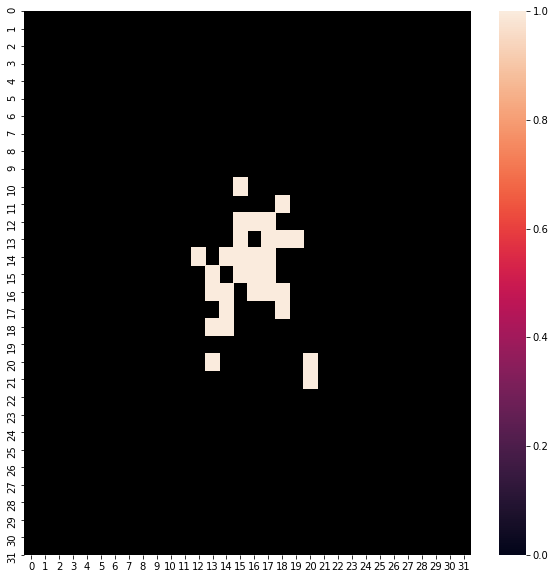

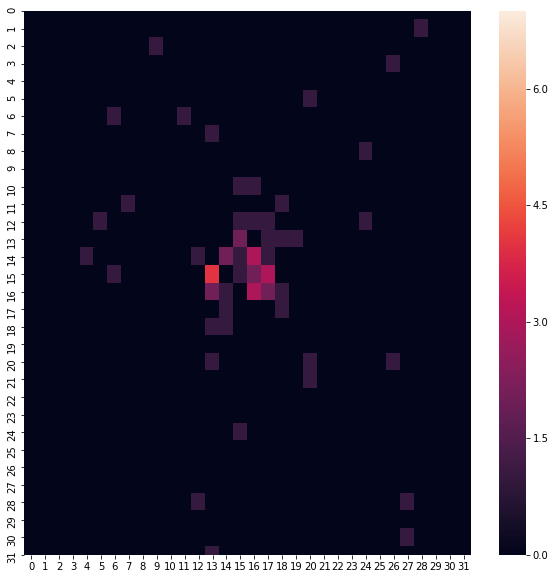

In [75]:
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['axes.facecolor'] = 'white'
plt.figure(figsize=(10,10))
mask = label_2d == 0.0
ax = sns.heatmap(label_2d, mask=mask, fmt=".2")
ax.set_facecolor("black")
# plt.title("Test truth label")
plt.show()

plt.figure(figsize=(10,10))
ax = sns.heatmap(image_2d, fmt=".2", vmax = 7)
ax.set_facecolor("black")
# plt.title("Test truth label")
plt.show()

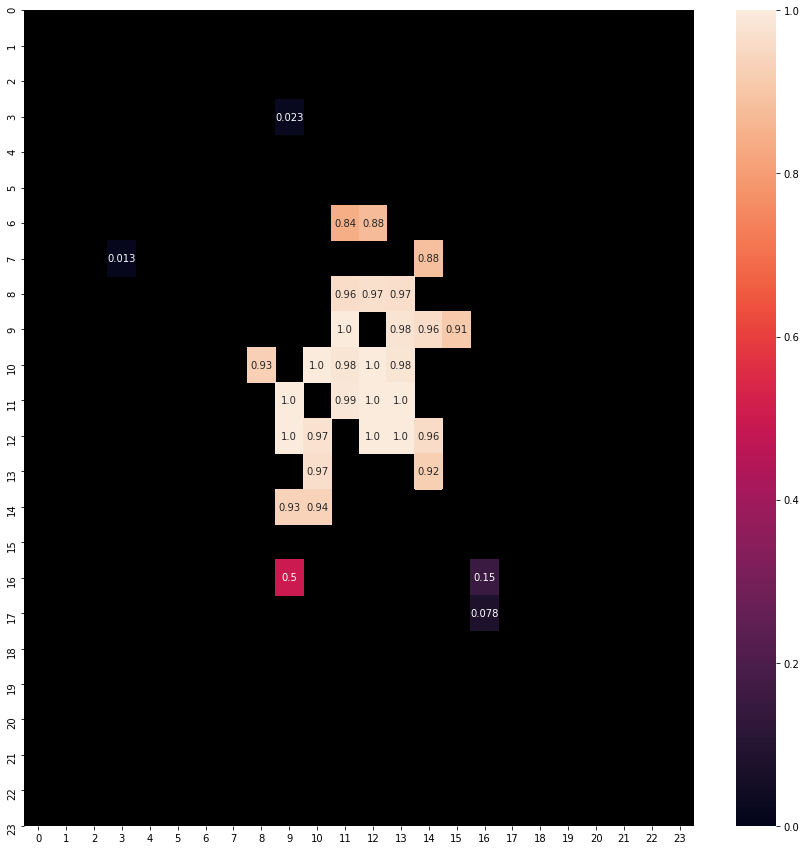

In [76]:
plt.figure(figsize=(15,15))
mask = pred_2d < 1e-2
ax = sns.heatmap(pred_2d[4:28, 4:28], mask=mask[4:28, 4:28], fmt=".2",annot=True)
ax.set_facecolor("black")
# plt.title("Prediction mask (showing scores)")
plt.show()